# Training a GAN with the MNIST dataset

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
bs = 128

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [4]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/home/leandro/anaconda3/envs/gpu/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [6]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [8]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim).to(device), torch.ones(x.size(0), 1).to(device)
    x_real, y_real = Variable(x_real), Variable(y_real) 

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(x.size(0), z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(x.size(0), 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [10]:
# Function to show generated images
def save_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = torch.randn(examples, z_dim, device=device)
    generated_images = G(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i].cpu().detach().numpy(), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"samples/gan_generated_image_epoch_{epoch}.png")
    #plt.close()

In [11]:
# Function to plot losses
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminative loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.suptitle('Loss over Epochs')
    plt.savefig('samples/losses.png')

[1/200]: loss_d: 0.845, loss_g: 3.835
[2/200]: loss_d: 0.669, loss_g: 4.345
[3/200]: loss_d: 0.705, loss_g: 3.978
[4/200]: loss_d: 0.712, loss_g: 3.646
[5/200]: loss_d: 0.688, loss_g: 3.484
[6/200]: loss_d: 0.629, loss_g: 3.477
[7/200]: loss_d: 0.605, loss_g: 3.444
[8/200]: loss_d: 0.589, loss_g: 3.408
[9/200]: loss_d: 0.581, loss_g: 3.351
[10/200]: loss_d: 0.579, loss_g: 3.289
[11/200]: loss_d: 0.572, loss_g: 3.256
[12/200]: loss_d: 0.576, loss_g: 3.191
[13/200]: loss_d: 0.581, loss_g: 3.130
[14/200]: loss_d: 0.587, loss_g: 3.076
[15/200]: loss_d: 0.598, loss_g: 3.008
[16/200]: loss_d: 0.607, loss_g: 2.948
[17/200]: loss_d: 0.618, loss_g: 2.890
[18/200]: loss_d: 0.628, loss_g: 2.838
[19/200]: loss_d: 0.637, loss_g: 2.795
[20/200]: loss_d: 0.643, loss_g: 2.754
[21/200]: loss_d: 0.651, loss_g: 2.713
[22/200]: loss_d: 0.660, loss_g: 2.673
[23/200]: loss_d: 0.668, loss_g: 2.634
[24/200]: loss_d: 0.674, loss_g: 2.603
[25/200]: loss_d: 0.681, loss_g: 2.571
[26/200]: loss_d: 0.688, loss_g: 2

/tmp/ipykernel_63920/2864726619.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


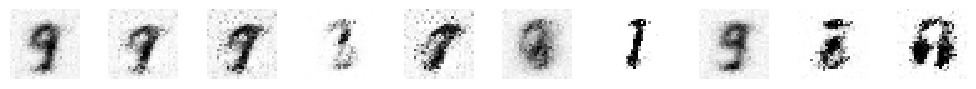

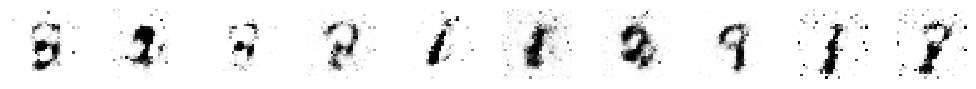

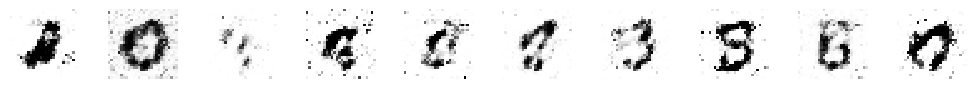

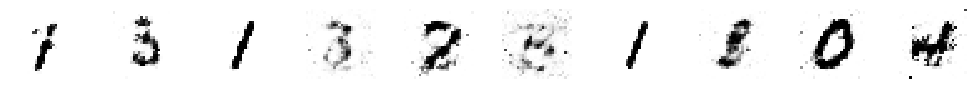

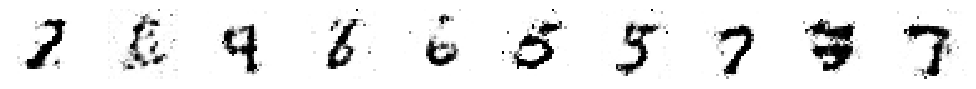

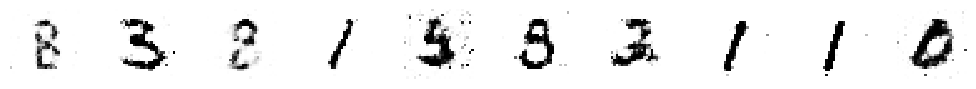

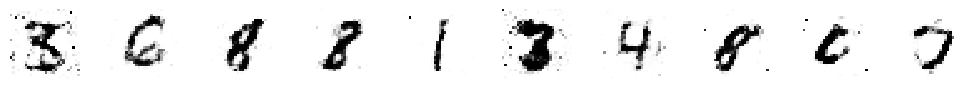

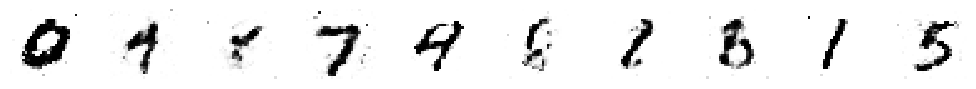

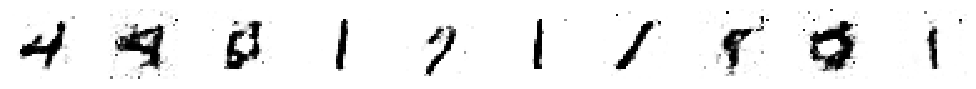

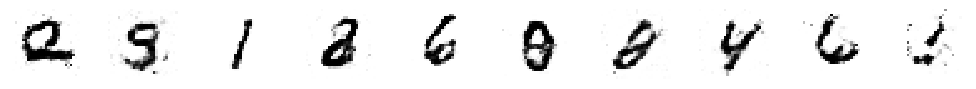

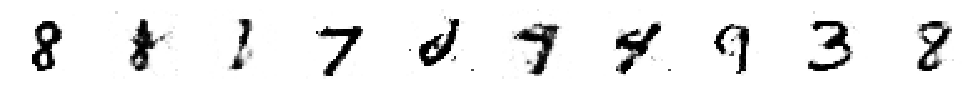

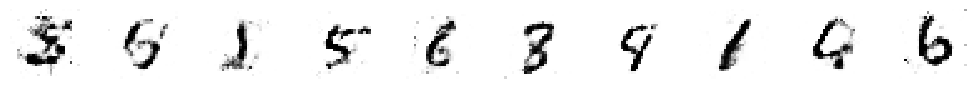

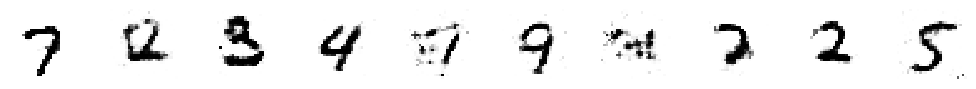

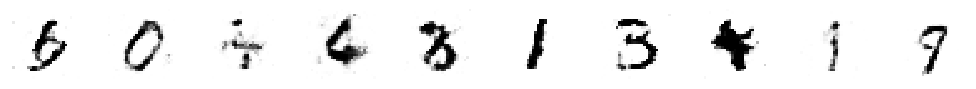

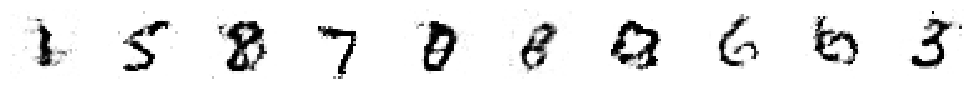

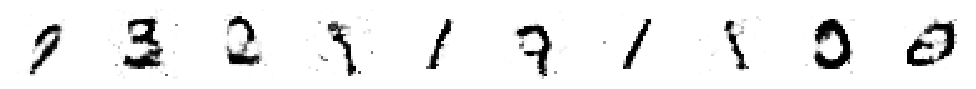

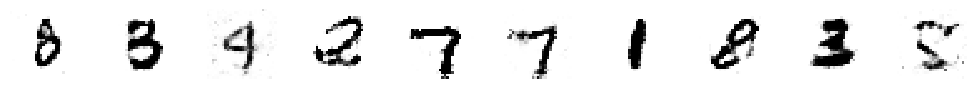

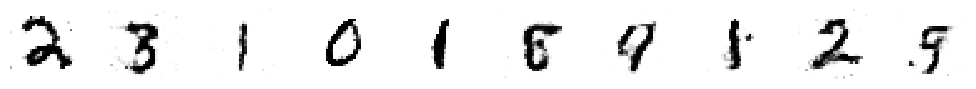

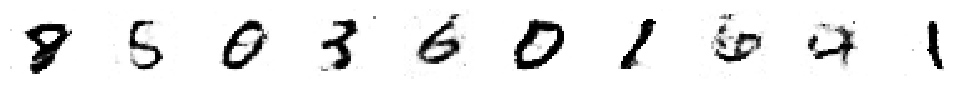

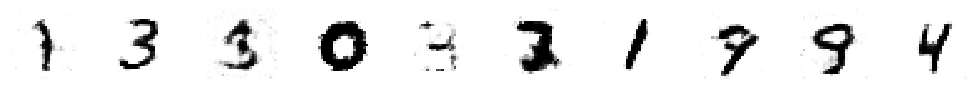

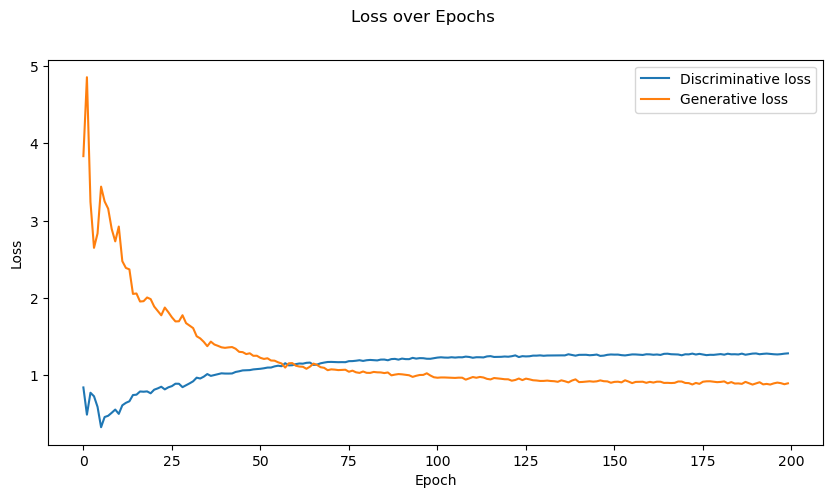

In [12]:
n_epoch = 200
sample_interval = 10
D_losses, G_losses = [], []
for epoch in range(1, n_epoch+1):              
    D_loss_epoch = 0.0
    G_loss_epoch = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        D_loss_epoch += D_train(x)
        G_loss_epoch += G_train(x)
    D_loss_epoch /= batch_idx+1
    G_loss_epoch /= batch_idx+1
    D_losses.append(D_loss_epoch)
    G_losses.append(G_loss_epoch)

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    if epoch % sample_interval == 0 or epoch==n_epoch:
        save_images(epoch,G)
        
plot_losses(D_losses, G_losses)